In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import matplotlib.cm as cm
from scipy.misc import imresize
import cv2
import pandas as pd
import scipy.io as io

In [2]:
def model_for_image(input_layer, drop_rate, name):

    x = (Conv2D(10, kernel_size=(4, 4), padding="same", 
                strides = (1, 1),activation= None,
                name = name +'_Layer_1'))(input_layer)
    x = (BatchNormalization(name = name +'_BN_1'))(x)
    x = (Activation('elu', name = name +'_act_1'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_1'))(x)

    # Layer 2
    x = (Conv2D(20, kernel_size=(5, 5), padding="valid", 
                strides = (1, 1),activation= None,
                name = name +'_Layer_2'))(x)
    x = (BatchNormalization(name = name +'BN_2'))(x)
    x = (Activation('elu', name = name +'_act_2'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_2'))(x)

    # Layer 3
    x = (Conv2D(20, kernel_size=(2, 2), padding="same",
                strides = (2, 2),activation= None,
                name = name +'_Layer_3'))(x)
    x = (BatchNormalization(name = name +'_BN_3'))(x)
    x = (Activation('elu', name = name +'_act_3'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_3'))(x)

    # Layer 4
    x = (Conv2D(40, kernel_size=(5, 5), padding= "valid",
            strides = (1, 1),activation= None,
            name = name +'_Layer_4'))(x)
    x = (BatchNormalization(name = name +'_BN_4'))(x)
    x = (Activation('elu',name = name +'_act_4'))(x)
    x = (Dropout(drop_rate,name = name +'_drop_4'))(x)

    # Layer 5
    x = (Conv2D(40, kernel_size=(2, 2), padding="same",
                strides = (2, 2) ,activation= None,
                name = name +'_Layer_5'))(x)
    x = (BatchNormalization(name = name +'_BN_5'))(x)
    x = (Activation('elu', name = name +'_act_5'))(x)
    x = (Dropout(drop_rate, name = name +'_drop'))(x)

    # Layer 6
    x = (Conv2D(80, kernel_size=(6, 6), padding="valid",
                strides = (1, 1),activation= None,
                name = name +'_Layer_6'))(x)
    x = (BatchNormalization(name = name +'_BN_6'))(x)
    x = (Activation('elu', name = name +'_act_6'))(x)
    x = (Dropout(drop_rate,name = name +'_drop_6'))(x)
    return x

In [3]:
def full_model(left_input, right_input, drop_out):
    
    # Make input layer
    # Build left layers and right layers
    left_model = model_for_image(left_input, drop_rate= drop_out, name='left')
    right_model = model_for_image(right_input, drop_rate= drop_out, name='right')
    # Merge left and right
    merge_layer = concatenate([left_model, right_model])
    merged = Flatten()(merge_layer)

    # Merge Layer 1
    x = (Dense(560, name = 'Merge_dense_1'))(merged)
    x = (BatchNormalization(name = 'Merge_BN_1'))(x)
    x = (Activation('elu', name = 'Merge_act_1'))(x)
    x = (Dropout(drop_rate, name = 'Merge_drop_1'))(x)
    
    # Merge Layer 2
    x = (Dense(280, name = 'Merge_dense_2'))(x)
    x = (BatchNormalization(name = 'Merge_BN_2'))(x)
    x = (Activation('elu', name = 'Merge_act_2'))(x)
    x = (Dropout(drop_rate, name = 'Merge_drop_2'))(x)
    
    # Merge Layer output
    x = (Dense(2, name = 'Merge_dense_3'))(x)
    x = (BatchNormalization(name = 'Merge_BN_3'))(x)
    x = (Activation('linear', name = 'Merge_act_3'))(x)
    out = (Dropout(drop_rate, name = 'Merge_drop_3'))(x)
    
    model = Model([left_input, right_input], out)
    return model

In [4]:
def data_extraction(path_left, path_right):
    img_path_left = glob(path_left + '/*.jpg')
    img_path_right = glob(path_right + '/*.jpg')
    img_path_left.sort()
    img_path_right.sort()
    data_right = []
    data_left = []
    for i in range(len(img_path_left)):
        img_left = cv2.imread(img_path_left[i], 0)
        img_right = cv2.imread(img_path_right[i], 0)
        data_left.append(img_left)
        data_right.append(img_right)
    return [data_right, data_left]

In [5]:
def label_extraction(path, screen_path):
    txt = pd.read_csv(path, sep = ' ', header= None)
    screen = io.loadmat(screen_path)
    df_anno = pd.DataFrame(txt)
    data_frame = pd.DataFrame()
    data_frame['Screen_x'] = df_anno[:][24] / screen['width_pixel'][0][0]
    data_frame['Screen_y'] = df_anno[:][25] / screen['height_pixel'][0][0]
    return data_frame

In [12]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [13]:
def path_optimization(day_list, path):
    all_path = []
    cnt = 0
    for i in range(len(day_list)): # 15번 
        temp = []
        for j in range(day_list[i]):
            temp.append(path[cnt])
            cnt += 1
        all_path.append(temp)
    return all_path

In [14]:
def make_dataset_img_label(image_shape, label_shape, data_list, label_list):
    length = len(data_list[0])
    left_img = np.zeros([length,image_shape])
    right_img = np.zeros([length,image_shape])
    label = np.zeros([length,label_shape])
    for n in range(length):
        left_img[n, :] = data_list[1][n].reshape(image_shape)
        right_img[n, :] = data_list[0][n].reshape(image_shape)
        label[n, :] = [label_list['Screen_x'][n], label_list['Screen_y'][n]]
        
    return right_img, left_img, label

def make_dataset_gaze_pose(data_shape, data_list):
    length = len(data_list[0])
    left_pose = np.zeros([length,data_shape])
    right_pose = np.zeros([length,data_shape])
    left_gaze = np.zeros([length,data_shape])
    right_gaze = np.zeros([length,data_shape])
    for n in range(length):
        left_gaze[n, :] = data_list[3][n]
        right_gaze[n, :] = data_list[2][n]
        left_pose[n, :] = data_list[5][n]
        right_pose[n, :] = data_list[4][n]
    return left_gaze, right_gaze, left_pose, right_pose

In [15]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


In [16]:
image_path_right = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Our_data_right/*/*/')
image_path_left = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Our_data_left/*/*/')
image_path_left.sort()
image_path_right.sort()

In [17]:
day_list = [39, 69, 39, 65, 25, 38, 62, 56, 47, 20, 16, 19, 7, 12, 7]  
image_path_left_op = path_optimization(day_list, image_path_left)
image_path_right_op = path_optimization(day_list, image_path_right)

label_path = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Original/*/*/annotation.txt') # 521개
label_path.sort()
label_path = path_optimization(day_list, label_path)
#label_path = path_optimzation(glob('C:/MPIIGaze/MPIIGaze/Data/Original/*/*/annotation.txt'))
screen_size_path = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Original/*/Calibration/screenSize.mat') # 15개

In [18]:
for i in range(15): # 총 15명
    data = [] # 사람별로 나눈 데이터
    label = [] # 사람별로 나눈 라벨   
    for j in range(day_list[i]): # 각 사람에 맞는 day만큼
        data.append(data_extraction(image_path_left_op[i][j], image_path_right_op[i][j]))
        label.append(label_extraction(label_path[i][j], screen_size_path[i]))
    exec('p%d_data = data' % (i))
    exec('p%d_label = label' % (i))

In [19]:
Batch_RE_img_data = []
Batch_LE_img_data = []
#Batch_LE_gaze_data = []
#Batch_RE_gaze_data = [] 
#Batch_LE_pose_data = []
#Batch_RE_pose_data = []
Batch_label = []
for i in range(15):
    for j in range(day_list[i]): #days list in Data  po -> 39days  ..
        exec('RE_img_data, LE_img_data, dataset_label = make_dataset_img_label(36 * 60, 2, p{0}_data[{1}], p{2}_label[{3}])'
             .format(i, j, i, j))
        Batch_RE_img_data.append(RE_img_data)
        Batch_LE_img_data.append(LE_img_data)
#         Batch_LE_gaze_data.append(LE_gaze_data)
#         Batch_RE_gaze_data.append(RE_gaze_data)
#         Batch_LE_pose_data.append(LE_pose_data)
#         Batch_RE_pose_data.append(RE_pose_data)
        Batch_label.append(dataset_label)

# Make graph for eye images

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input

In [15]:
tf.reset_default_graph()

In [16]:
row, col, channel = 36, 60, 1
drop_rate = 0.3
left_input = Input(shape=(row, col, channel,), name = 'left_eye_input')
right_input = Input(shape=(row, col, channel,), name= 'right_eye_input')

In [17]:
# Left eye Layers
name = 'left'

with tf.name_scope(name + '_layer_1'):
    x = (Conv2D(10, kernel_size=(4, 4), padding="same", 
                    strides = (1, 1),activation= None,
                    name = name +'_Layer_1'))(left_input)
    x = (BatchNormalization(name = name +'_BN_1'))(x)
    x = (Activation('elu', name = name +'_act_1'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_1'))(x)
    
# Layer 2
with tf.name_scope(name + '_layer_2'):
    x = (Conv2D(20, kernel_size=(5, 5), padding="valid", 
                strides = (1, 1),activation= None,
                name = name +'_Layer_2'))(x)
    x = (BatchNormalization(name = name +'BN_2'))(x)
    x = (Activation('elu', name = name +'_act_2'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_2'))(x)
    
# Layer 3
with tf.name_scope(name + '_layer_3'):
    x = (Conv2D(20, kernel_size=(2, 2), padding="same",
                strides = (2, 2),activation= None,
                name = name +'_Layer_3'))(x)
    x = (BatchNormalization(name = name +'_BN_3'))(x)
    x = (Activation('elu', name = name +'_act_3'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_3'))(x)
    
# Layer 4
with tf.name_scope(name + '_layer_4'):
    x = (Conv2D(40, kernel_size=(5, 5), padding= "valid",
            strides = (1, 1),activation= None,
            name = name +'_Layer_4'))(x)
    x = (BatchNormalization(name = name +'_BN_4'))(x)
    x = (Activation('elu',name = name +'_act_4'))(x)
    x = (Dropout(drop_rate,name = name +'_drop_4'))(x)
    
# Layer 5
with tf.name_scope(name + '_layer_5'):
    x = (Conv2D(40, kernel_size=(2, 2), padding="same",
                strides = (2, 2) ,activation= None,
                name = name +'_Layer_5'))(x)
    x = (BatchNormalization(name = name +'_BN_5'))(x)
    x = (Activation('elu', name = name +'_act_5'))(x)
    x = (Dropout(drop_rate, name = name +'_drop'))(x)
    
# Layer 6
with tf.name_scope(name + '_layer_6'):
    x = (Conv2D(80, kernel_size=(6, 6), padding="valid",
                strides = (1, 1),activation= None,
                name = name +'_Layer_6'))(x)
    x = (BatchNormalization(name = name +'_BN_6'))(x)
    x = (Activation('elu', name = name +'_act_6'))(x)
    left_x = (Dropout(drop_rate,name = name +'_drop_6'))(x)

W0925 12:46:53.035381 140129819678464 deprecation.py:506] From /home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
# Right eye layers
name = 'right'
with tf.name_scope(name + '_layer_1'):
    x = (Conv2D(10, kernel_size=(4, 4), padding="same", 
                    strides = (1, 1),activation= None,
                    name = name +'_Layer_1'))(right_input)
    x = (BatchNormalization(name = name +'_BN_1'))(x)
    x = (Activation('elu', name = name +'_act_1'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_1'))(x)
    
# Layer 2
with tf.name_scope(name + '_layer_2'):
    x = (Conv2D(20, kernel_size=(5, 5), padding="valid", 
                strides = (1, 1),activation= None,
                name = name +'_Layer_2'))(x)
    x = (BatchNormalization(name = name +'BN_2'))(x)
    x = (Activation('elu', name = name +'_act_2'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_2'))(x)
    
# Layer 3
with tf.name_scope(name + '_layer_3'):
    x = (Conv2D(20, kernel_size=(2, 2), padding="same",
                strides = (2, 2),activation= None,
                name = name +'_Layer_3'))(x)
    x = (BatchNormalization(name = name +'_BN_3'))(x)
    x = (Activation('elu', name = name +'_act_3'))(x)
    x = (Dropout(drop_rate, name = name +'_drop_3'))(x)
    
# Layer 4
with tf.name_scope(name + '_layer_4'):
    x = (Conv2D(40, kernel_size=(5, 5), padding= "valid",
            strides = (1, 1),activation= None,
            name = name +'_Layer_4'))(x)
    x = (BatchNormalization(name = name +'_BN_4'))(x)
    x = (Activation('elu',name = name +'_act_4'))(x)
    x = (Dropout(drop_rate,name = name +'_drop_4'))(x)
    
# Layer 5
with tf.name_scope(name + '_layer_5'):
    x = (Conv2D(40, kernel_size=(2, 2), padding="same",
                strides = (2, 2) ,activation= None,
                name = name +'_Layer_5'))(x)
    x = (BatchNormalization(name = name +'_BN_5'))(x)
    x = (Activation('elu', name = name +'_act_5'))(x)
    x = (Dropout(drop_rate, name = name +'_drop'))(x)
    
# Layer 6
with tf.name_scope(name + '_layer_6'):
    x = (Conv2D(80, kernel_size=(6, 6), padding="valid",
                strides = (1, 1),activation= None,
                name = name +'_Layer_6'))(x)
    x = (BatchNormalization(name = name +'_BN_6'))(x)
    x = (Activation('elu', name = name +'_act_6'))(x)
    right_x = (Dropout(drop_rate,name = name +'_drop_6'))(x)

In [19]:
# Merge layer

merge_layer = concatenate([left_x, right_x])
merged = Flatten()(merge_layer)

with tf.name_scope('merge_layer_1'):
    x = (Dense(560, name = 'Merge_dense_1'))(merged)
    x = (BatchNormalization(name = 'Merge_BN_1'))(x)
    x = (Activation('elu', name = 'Merge_act_1'))(x)
    x = (Dropout(drop_rate, name = 'Merge_drop_1'))(x)
    
# Merge Layer 2
with tf.name_scope('merge_layer_2'):
    x = (Dense(280, name = 'Merge_dense_2'))(x)
    x = (BatchNormalization(name = 'Merge_BN_2'))(x)
    x = (Activation('elu', name = 'Merge_act_2'))(x)
    x = (Dropout(drop_rate, name = 'Merge_drop_2'))(x)
    
# Merge Layer output
with tf.name_scope('merge_layer_3'):
    x = (Dense(2, name = 'Merge_dense_3'))(x)
    x = (BatchNormalization(name = 'Merge_BN_3'))(x)
    x = (Activation('linear', name = 'Merge_act_3'))(x)
    out = (Dropout(drop_rate, name = 'Merge_drop_3'))(x)

In [20]:
model = Model([left_input, right_input], out)

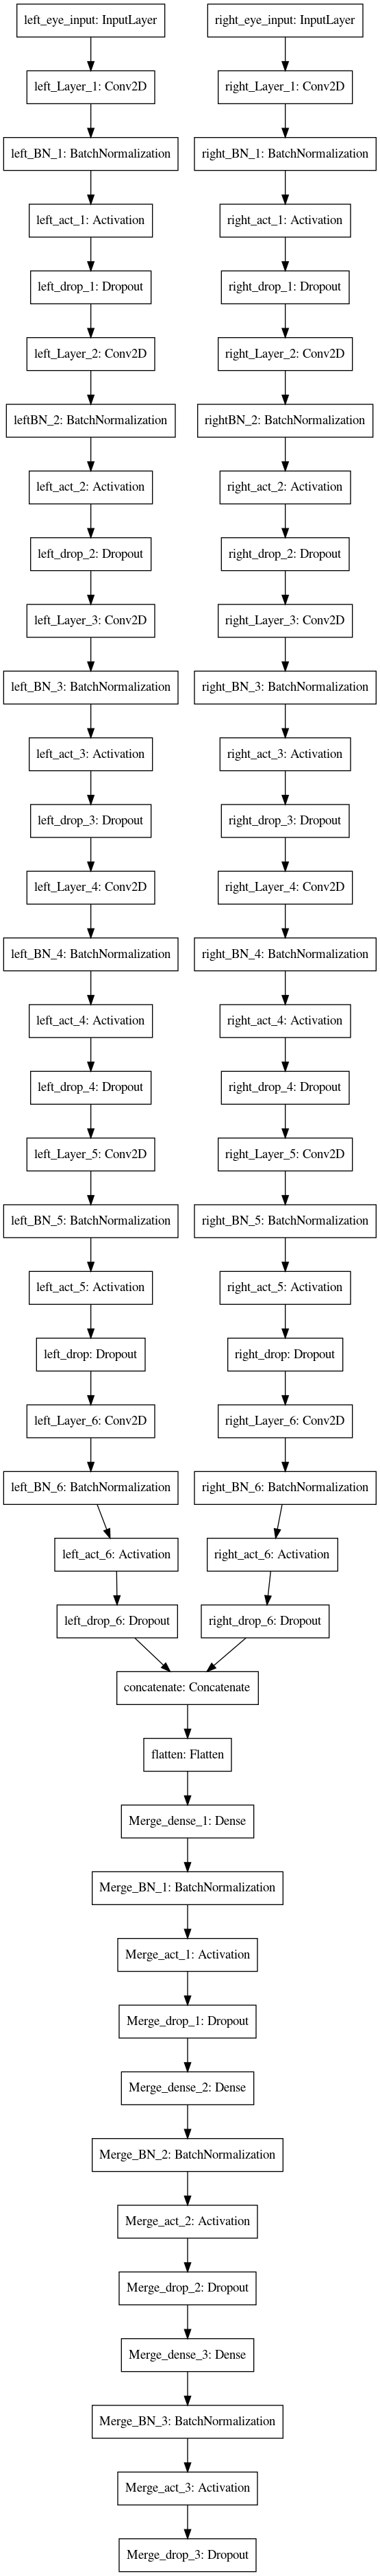

In [ ]:
#plot_model(model)

In [21]:
show_graph(tf.get_default_graph())

In [28]:
cnt = 0
for i in Batch_LE_img_data:
    for j in range(len(i)):
        cnt += 1
        
LE_image = np.zeros([cnt, 36, 60, 1])
RE_image = np.zeros([cnt, 36, 60, 1])
label = np.zeros([cnt, 2])

In [29]:
n = 0
for i in range(len(Batch_LE_img_data)):
    for j in range(len(Batch_LE_img_data[i])):
        LE_image[n, :] = Batch_LE_img_data[i][j].reshape(36, 60, 1)
        RE_image[n, :] = Batch_RE_img_data[i][j].reshape(36, 60, 1)
        label[n, :] = Batch_label[i][j]
        n += 1

In [30]:
from sklearn.model_selection import train_test_split

LE_X_train, LE_X_test, Y_train, Y_test = train_test_split(LE_image, label, test_size=0.33, random_state=42)
RE_X_train, RE_X_test, _, _ = train_test_split(RE_image, label, test_size=0.33, random_state=42)

In [25]:
LE_X, RE_X = LE_X_train[:100000],RE_X_train[:100000]
LE_X_val, RE_X_val = LE_X_train[100000:], RE_X_train[100000:]
Y = Y_train[:100000]
Y_val = Y_train[100000:]

In [28]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss = 'mse', optimizer= opt, metrics=['mean_absolute_error'])

In [29]:
train_history = model.fit([LE_X, RE_X], Y, epochs= 10, batch_size= 500, 
                          validation_data=([LE_X_val, RE_X_val], Y_val), verbose= 1)

Train on 100000 samples, validate on 43150 samples
Epoch 1/10
100000/100000 [==============================] - 371s 4ms/sample - loss: 1.1026 - mean_absolute_error: 0.8187 - val_loss: 1.5481 - val_mean_absolute_error: 1.0179
Epoch 2/10
100000/100000 [==============================] - 370s 4ms/sample - loss: 0.6260 - mean_absolute_error: 0.6451 - val_loss: 0.5810 - val_mean_absolute_error: 0.6229
Epoch 3/10
100000/100000 [==============================] - 380s 4ms/sample - loss: 0.3820 - mean_absolute_error: 0.5140 - val_loss: 0.1775 - val_mean_absolute_error: 0.3468
Epoch 4/10
100000/100000 [==============================] - 381s 4ms/sample - loss: 0.2509 - mean_absolute_error: 0.4138 - val_loss: 0.0964 - val_mean_absolute_error: 0.2540
Epoch 5/10
100000/100000 [==============================] - 381s 4ms/sample - loss: 0.1827 - mean_absolute_error: 0.3395 - val_loss: 0.0563 - val_mean_absolute_error: 0.1940
Epoch 6/10
100000/100000 [==============================] - 380s 4ms/sample - l

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
    
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
temp =model.predict(x=[LE_X_test, RE_X_test])

In [32]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_test, temp)

0.044760085948762615

In [41]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()


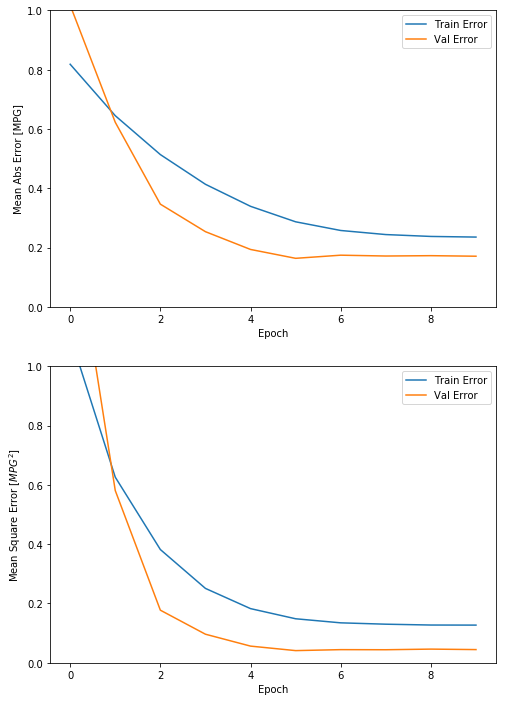

In [42]:
plot_history(train_history)

In [23]:
from tensorflow.keras.models import model_from_json 
json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

W0925 17:43:32.772221 140650975913728 deprecation.py:506] From /home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0925 17:43:32.773072 140650975913728 deprecation.py:506] From /home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0925 17:43:32.773761 140650975913728 deprecation.py:506] From /home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tenso

In [24]:
show_graph(tf.get_default_graph())

In [25]:
loaded_model.load_weights("model.h5")

In [27]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
loaded_model.compile(loss = 'mse', optimizer= opt, metrics=['mean_absolute_error'])

In [31]:
loaded_model.evaluate([LE_X_test, RE_X_test], Y_test)

70508/70508 [==============================] - 31s 441us/sample - loss: 0.0448 - mean_absolute_error: 0.1720


[0.04476008605276009, 0.1719921]